In [1]:
from src.models.lbcnn.lbcnn_parts import ConvLBP
from src.models.dsc.dsc_lbc_unet import DSCConvLBP
import torch.nn as nn
import torch
from src.models.lbcnn.lbc_unet import UNetLBP, SmallUNetLBP, SkinnySmallUNetLBP
from src.datasets.ice import Ice
from torch.utils.data import DataLoader
import os
import matplotlib.pyplot as plt
import numpy as np

In [2]:
activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

In [3]:
layer1 = nn.Conv2d(3, 3, kernel_size=3)
layer2 = ConvLBP(3, 3)

In [4]:
print(layer1.weight.data.numpy().shape)
print(layer2.weight.data.numpy().shape)

(3, 3, 3, 3)
(3, 3, 3, 3)


In [5]:
weights1 = layer1.weight.data.numpy()
weights2 = layer2.weight.data.numpy()

In [6]:
weights1[0]

array([[[ 0.06693798,  0.02448413, -0.05976971],
        [-0.13521382, -0.08119002,  0.13640775],
        [ 0.10260162, -0.1018449 ,  0.13203113]],

       [[ 0.05936882,  0.05813891, -0.06583867],
        [-0.12298512, -0.08339822,  0.11877967],
        [-0.17904194,  0.13762522, -0.15370178]],

       [[ 0.16089162, -0.14135368,  0.1432383 ],
        [-0.12777874, -0.08937232,  0.06279   ],
        [-0.00451993,  0.05954359,  0.12504548]]], dtype=float32)

In [7]:
weights2[0]

array([[[-1.,  0.,  0.],
        [ 1., -1.,  0.],
        [ 0., -1.,  0.]],

       [[ 1.,  1.,  1.],
        [ 1.,  0.,  0.],
        [-1.,  0.,  0.]],

       [[-1.,  0.,  1.],
        [ 0.,  0.,  0.],
        [ 1.,  0., -1.]]], dtype=float32)

In [8]:
weights = next(layer1.parameters())

In [9]:
matrix_proba = torch.FloatTensor(weights.data.shape).fill_(0.5)

In [10]:
binary_weights = torch.bernoulli(matrix_proba) * 2 - 1

In [11]:
torch.rand(matrix_proba.shape) > 0

tensor([[[[True, True, True],
          [True, True, True],
          [True, True, True]],

         [[True, True, True],
          [True, True, True],
          [True, True, True]],

         [[True, True, True],
          [True, True, True],
          [True, True, True]]],


        [[[True, True, True],
          [True, True, True],
          [True, True, True]],

         [[True, True, True],
          [True, True, True],
          [True, True, True]],

         [[True, True, True],
          [True, True, True],
          [True, True, True]]],


        [[[True, True, True],
          [True, True, True],
          [True, True, True]],

         [[True, True, True],
          [True, True, True],
          [True, True, True]],

         [[True, True, True],
          [True, True, True],
          [True, True, True]]]])

In [12]:
nn.Conv2d(3, 64, kernel_size=1).weight.data.numpy().shape

(64, 3, 1, 1)

In [13]:
device = 'cpu'
checkpoint = 'helpful_jazz_378_skinny_small_lbc_unet_no_conv_no_batch_norm'
epoch = 40
checkpoint_path = f'/home/dsola/repos/PGA-Net/checkpoints/{checkpoint}/epoch{epoch + 1}.pth'
net = SkinnySmallUNetLBP(3, 3)
net.load_state_dict(torch.load(checkpoint_path, map_location=device))

<All keys matched successfully>

In [14]:
data_dir = '/home/dsola/repos/PGA-Net/data/'
batch_size = 1
img_scale = 0.35
img_crop = 256

test_set = Ice(os.path.join(data_dir, 'imgs'), os.path.join(data_dir, 'masks'),
              os.path.join(data_dir, 'txt_files'), 'val', img_scale, img_crop)

test_loader = DataLoader(test_set, batch_size=batch_size)

out = nn.Softmax(dim=1)

In [15]:
for batch in test_loader:
    pass

In [16]:
img = batch['image'].to(device=device)

In [17]:
img.shape

torch.Size([1, 3, 256, 256])

In [18]:
output = net(img)
sftmx = out(output)
argmx = torch.argmax(sftmx, dim=1)

/home/dsola/anaconda3/envs/PGA-Net/lib/python3.8/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


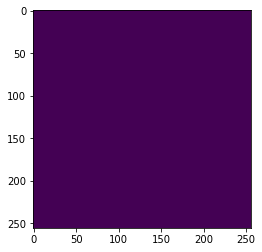

In [19]:
argmx_np = argmx.squeeze(0).detach().numpy()
plt.imshow(argmx_np)

In [20]:
img.shape

torch.Size([1, 3, 256, 256])

In [22]:
net

SkinnySmallUNetLBP(
  (inc): BlockLBPUNet(
    (conv_1x1): Conv2d(3, 32, kernel_size=(1, 1), stride=(1, 1))
  )
  (down1): DownLBP(
    (maxpool_conv): Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): BlockLBPUNet(
        (conv_1x1): Conv2d(32, 64, kernel_size=(1, 1), stride=(1, 1))
      )
    )
  )
  (down2): DownLBP(
    (maxpool_conv): Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): BlockLBPUNet(
        (conv_1x1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
      )
    )
  )
  (up1): UpLBP(
    (up): Upsample(scale_factor=2.0, mode=bilinear)
    (conv): BlockLBPUNet(
      (conv_1x1): Conv2d(128, 32, kernel_size=(1, 1), stride=(1, 1))
    )
  )
  (up2): UpLBP(
    (up): Upsample(scale_factor=2.0, mode=bilinear)
    (conv): BlockLBPUNet(
      (conv_1x1): Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1))
    )
  )
  (outc): BlockLBPUNet(
    (conv_1x1): C

In [23]:
net.inc.conv_1x1.register_forward_hook(get_activation('inc_conv_1x1'))
net.down1.maxpool_conv[0].register_forward_hook(get_activation('down1_mp'))
net.down1.maxpool_conv[1].conv_1x1.register_forward_hook(get_activation('down1_conv_1x1'))

output = net(img)

In [24]:
activation['inc_conv_1x1'].shape

torch.Size([1, 32, 256, 256])

In [25]:
activation['inc_conv_1x1']

tensor([[[[ 5.3223e-01,  5.3220e-01,  5.3219e-01,  ...,  5.3296e-01,
            5.3281e-01,  5.3278e-01],
          [ 5.3230e-01,  5.3226e-01,  5.3223e-01,  ...,  5.3291e-01,
            5.3300e-01,  5.3344e-01],
          [ 5.3184e-01,  5.3159e-01,  5.3116e-01,  ...,  5.3314e-01,
            5.3351e-01,  5.3375e-01],
          ...,
          [ 5.3144e-01,  5.3133e-01,  5.3157e-01,  ...,  5.3202e-01,
            5.3192e-01,  5.3205e-01],
          [ 5.3066e-01,  5.2915e-01,  5.2989e-01,  ...,  5.3213e-01,
            5.3204e-01,  5.3217e-01],
          [ 5.2865e-01,  5.2786e-01,  5.2867e-01,  ...,  5.3195e-01,
            5.3179e-01,  5.3177e-01]],

         [[-2.9427e+00, -2.9425e+00, -2.9426e+00,  ..., -2.9439e+00,
           -2.9435e+00, -2.9429e+00],
          [-2.9429e+00, -2.9428e+00, -2.9427e+00,  ..., -2.9436e+00,
           -2.9436e+00, -2.9440e+00],
          [-2.9419e+00, -2.9413e+00, -2.9402e+00,  ..., -2.9441e+00,
           -2.9445e+00, -2.9446e+00],
          ...,
     